In [1]:
!pip install -r requirements-pube.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/share/miniconda3/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import PIL

In [3]:
PIL.__version__

'6.2.2'

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os
import datetime
import json
import yaml
from collections import defaultdict, Counter
from copy import deepcopy
from importlib import reload
from collections import Counter

In [5]:
%matplotlib inline

In [6]:
F.gumbel_softmax

<function torch.nn.functional.gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1)>

In [7]:
#Add synchronized directory
#Remember to keep up to date on the local machine 
distsup_dir = "/home/jovyan/Documents/DistSup"
import sys
sys.path.append(distsup_dir)

In [8]:
from distsup import reconstructors_analysis
from distsup.reconstructors_analysis import style_modeling
from distsup.reconstructors_analysis.style_modeling.qmnist.dataset import get_dataset, get_full_dataset
from distsup.modules import pixcnn
from distsup.modules import quantizers

In [9]:
from distsup import utils
from distsup.modules import reconstructors, encoders, pixcnn
from distsup.models import vqvae, minitest, representation_learners
from distsup.data import PaddedDatasetLoader, FixedDatasetLoader, ChunkedDataset
from egs.mnist_seq.data import MNISTSequentialDataset

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cuda')

## Classes

In [12]:
num_levels = 16

In [13]:
class MnistStyleModel(nn.Module):
    def __init__(self, activation=F.leaky_relu):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 16, kernel_size=3)
        self.dropout = nn.Dropout2d()
        self.activation = activation

    def forward(self, x):
        if len(x.shape) == 3:
            x = x[None, :]
        x = self.activation(F.max_pool2d(self.conv1(x), 2))
        x = self.dropout(x)
        x = self.activation(F.max_pool2d(self.conv2(x), 2))
        x = self.dropout(x)
        x = self.activation(self.conv3(x))
        return x.view(x.size(0), -1)

    @staticmethod
    def get_inputs(data, num_levels):
        x = data["images"].to(device)
        return (x * num_levels).clamp(0, num_levels - 1) / (num_levels - 1)

In [14]:
style_sizes = [8] #[1,2,4,8,16,32]

In [16]:
qmnist_full_train_set, qmnist_full_test_set = get_full_dataset(9, max_train_samples=60000)

In [17]:
len(qmnist_full_train_set.author_id_to_range)

4101

In [18]:
len(qmnist_full_train_set)

60000

In [19]:
len(qmnist_full_train_set.dataset)

402953

In [20]:
train_loader = torch.utils.data.DataLoader(qmnist_full_train_set, batch_size=64, num_workers=1, shuffle=True)   
test_loader = torch.utils.data.DataLoader(qmnist_full_test_set, batch_size=64, num_workers=1, shuffle=False)   


In [21]:
embedding_size = 10

In [22]:
digit_cond = [{
    'cond_dim': 144,
    'reduction_factor': 0,
},
{
    'cond_dim': 10,
    'reduction_factor': 0,
}]

In [23]:
temperatures = [0.1, 0.5, 1.0]

In [26]:
models = {i: pixcnn.GatedPixelCNN(quantizer=dict(
                     class_name=quantizers.SoftmaxUniformQuantizer,
                     num_levels=num_levels
                     ),
                     cond_channels=digit_cond).to(device)
         for i in temperatures}

In [27]:
style_models = {
    i: MnistStyleModel().to(device)
    for i in temperatures
}

In [28]:
from distsup.reconstructors_analysis.style_modeling import trainer, embedded

In [29]:
class GumbelSoftmax(nn.Softmax):
    def __init__(self, temperature, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.temperature = temperature
        
    def forward(self, input):
        return F.gumbel_softmax(input, self.temperature, dim=self.dim)

In [30]:
embeddings = {
    i: embedded.MaskedEmbedding(len(qmnist_full_train_set), 10, mask=GumbelSoftmax(i, dim=-1)).to(device)
    for i in temperatures
}

In [31]:
class PixelCnnEmbeddingAuthorDigitsTrainer(trainer.PixelCnnWithEmbeddingTrainer):
    def get_conditioning(self, data):
        batch_size = data["target_image_label"].size(0)
        target_class_label = data["target_image_label"]
        author_id = data["author_id"]
        embedding_idx = author_id * 10 + target_class_label
        digit_cond = self.embedding(
            embedding_idx.to(self.device)
        ).view(batch_size, 1, 1, -1)
        return self.get_style_vector(data), digit_cond

In [32]:
trainers = {
    i: PixelCnnEmbeddingAuthorDigitsTrainer(
        models[i], 
        style_models[i], 
        train_loader,
        embedding=embeddings[i],
        serialization_filename=f"PixelCNN_embedding_author_digits_with_gumbel_softmax_temp_{i}_60000_dataset_averaged_style_inputs_8",
        serialization_path="models/PixelCNN_embedding")
    for i in temperatures
}

In [33]:
optims = {
    i: optim.Adam(models[i].parameters(), lr=1e-4)
    for i in temperatures
}

In [34]:
style_optims = {
    i: optim.Adam(style_models[i].parameters(), lr=1e-4) 
    for i in temperatures
}

In [35]:
emb_optims = {
    i: optim.Adam(embeddings[i].parameters(), lr=1e-4) 
    for i in temperatures
}

In [36]:
num_epochs = 50

In [37]:
for i in temperatures:
    print(f"Starting temperature {i} training")
    trainers[i].train([optims[i], style_optims[i], emb_optims[i]], num_epochs)

Starting temperature 0.1 training
Train Epoch: 1 [0/60000 (0%)]	Loss: 146213.078125
Train Epoch: 1 [6400/60000 (11%)]	Loss: 86825.507812
Train Epoch: 1 [12800/60000 (21%)]	Loss: 48633.703125
Train Epoch: 1 [19200/60000 (32%)]	Loss: 44850.445312
Train Epoch: 1 [25600/60000 (43%)]	Loss: 41197.539062
Train Epoch: 1 [32000/60000 (53%)]	Loss: 41842.992188
Train Epoch: 1 [38400/60000 (64%)]	Loss: 39644.585938
Train Epoch: 1 [44800/60000 (75%)]	Loss: 35795.070312
Train Epoch: 1 [51200/60000 (85%)]	Loss: 31443.125000
Train Epoch: 1 [57600/60000 (96%)]	Loss: 29232.937500
Train Epoch: 2 [0/60000 (0%)]	Loss: 27586.011719
Train Epoch: 2 [6400/60000 (11%)]	Loss: 26788.449219
Train Epoch: 2 [12800/60000 (21%)]	Loss: 24265.474609
Train Epoch: 2 [19200/60000 (32%)]	Loss: 22844.753906
Train Epoch: 2 [25600/60000 (43%)]	Loss: 22182.589844
Train Epoch: 2 [32000/60000 (53%)]	Loss: 21963.671875
Train Epoch: 2 [38400/60000 (64%)]	Loss: 21648.847656
Train Epoch: 2 [44800/60000 (75%)]	Loss: 20250.230469
Train

In [38]:
optims = {
    i: optim.Adam(models[i].parameters(), lr=1e-3)
    for i in temperatures
}

In [39]:
style_optims = {
    i: optim.Adam(style_models[i].parameters(), lr=1e-3) 
    for i in temperatures
}

In [40]:
emb_optims = {
    i: optim.Adam(embeddings[i].parameters(), lr=1e-3) 
    for i in temperatures
}

In [41]:
for i in temperatures:
    print(f"Starting temperature {i} training")
    trainers[i].train([optims[i], style_optims[i], emb_optims[i]], num_epochs)

Starting temperature 0.1 training
Train Epoch: 1 [0/60000 (0%)]	Loss: 15653.690430
Train Epoch: 1 [6400/60000 (11%)]	Loss: 16612.660156
Train Epoch: 1 [12800/60000 (21%)]	Loss: 17059.794922
Train Epoch: 1 [19200/60000 (32%)]	Loss: 16990.044922
Train Epoch: 1 [25600/60000 (43%)]	Loss: 16088.405273
Train Epoch: 1 [32000/60000 (53%)]	Loss: 15917.900391
Train Epoch: 1 [38400/60000 (64%)]	Loss: 16240.099609
Train Epoch: 1 [44800/60000 (75%)]	Loss: 14862.216797
Train Epoch: 1 [51200/60000 (85%)]	Loss: 16236.949219
Train Epoch: 1 [57600/60000 (96%)]	Loss: 16090.134766
Train Epoch: 2 [0/60000 (0%)]	Loss: 15430.916992
Train Epoch: 2 [6400/60000 (11%)]	Loss: 15994.092773
Train Epoch: 2 [12800/60000 (21%)]	Loss: 16087.708984
Train Epoch: 2 [19200/60000 (32%)]	Loss: 15604.416016
Train Epoch: 2 [25600/60000 (43%)]	Loss: 16246.134766
Train Epoch: 2 [32000/60000 (53%)]	Loss: 14951.511719
Train Epoch: 2 [38400/60000 (64%)]	Loss: 15992.633789
Train Epoch: 2 [44800/60000 (75%)]	Loss: 16588.753906
Train 

In [42]:
optims = {
    i: optim.Adam(models[i].parameters(), lr=1e-4)
    for i in temperatures
}

In [43]:
style_optims = {
    i: optim.Adam(style_models[i].parameters(), lr=1e-4) 
    for i in temperatures
}

In [44]:
emb_optims = {
    i: optim.Adam(embeddings[i].parameters(), lr=1e-4) 
    for i in temperatures
}

In [45]:
for i in temperatures:
    print(f"Starting temperature {i} training")
    trainers[i].train([optims[i], style_optims[i], emb_optims[i]], num_epochs)
    print("Serializing model")
    trainers[i].serialize([optims[i], style_optims[i], emb_optims[i]])

Starting temperature 0.1 training
Train Epoch: 1 [0/60000 (0%)]	Loss: 14535.689453
Train Epoch: 1 [6400/60000 (11%)]	Loss: 15153.271484
Train Epoch: 1 [12800/60000 (21%)]	Loss: 14121.117188
Train Epoch: 1 [19200/60000 (32%)]	Loss: 14024.800781
Train Epoch: 1 [25600/60000 (43%)]	Loss: 14354.458984
Train Epoch: 1 [32000/60000 (53%)]	Loss: 14436.387695
Train Epoch: 1 [38400/60000 (64%)]	Loss: 14094.599609
Train Epoch: 1 [44800/60000 (75%)]	Loss: 14078.992188
Train Epoch: 1 [51200/60000 (85%)]	Loss: 14125.675781
Train Epoch: 1 [57600/60000 (96%)]	Loss: 14195.811523
Train Epoch: 2 [0/60000 (0%)]	Loss: 13802.127930
Train Epoch: 2 [6400/60000 (11%)]	Loss: 15006.707031
Train Epoch: 2 [12800/60000 (21%)]	Loss: 13715.718750
Train Epoch: 2 [19200/60000 (32%)]	Loss: 14736.555664
Train Epoch: 2 [25600/60000 (43%)]	Loss: 13906.302734
Train Epoch: 2 [32000/60000 (53%)]	Loss: 14623.685547
Train Epoch: 2 [38400/60000 (64%)]	Loss: 14527.874023
Train Epoch: 2 [44800/60000 (75%)]	Loss: 14218.901367
Train 

In [46]:
rec_losses = {
    i: [r.mean().item() for r in trainers[i].recon_losses] for i in temperatures
}

In [47]:
for i, r in rec_losses.items():
    print(i, r[-1], len(r))

0.1 0.2985805869102478 150
0.5 0.28989678621292114 130
1.0 0.2937493920326233 133


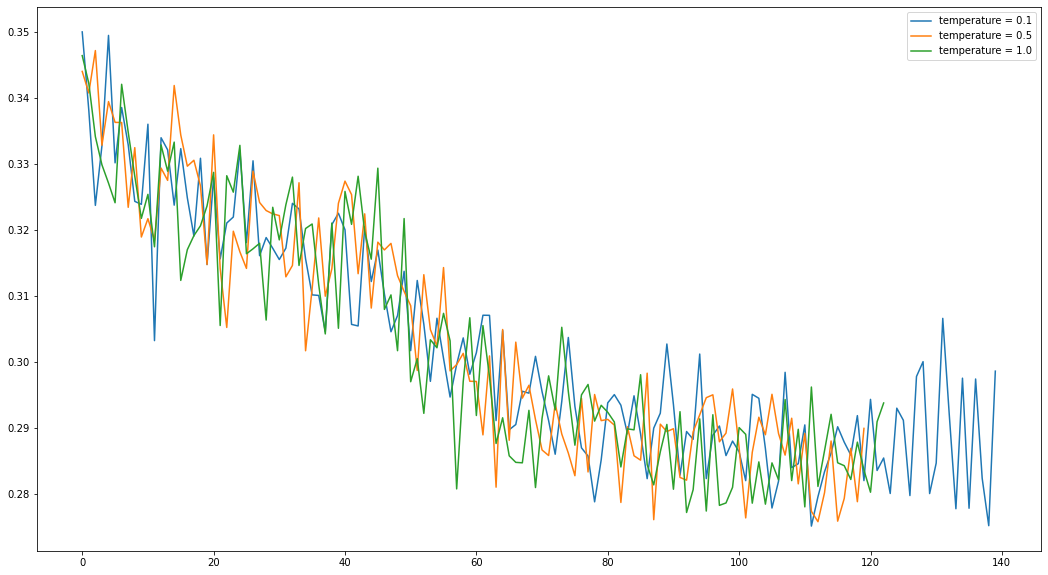

In [48]:
fig = plt.figure(figsize=(18,10))
for s in temperatures:
    plt.plot(np.arange(len(rec_losses[s]) - 10), rec_losses[s][10:], label=f"temperature = {s}")
plt.legend()

In [27]:
models_path = "models/PixelCNN_embedding"
model_file_tpl = "PixelCNN_embedding_dim_{}_with_gumbel_softmax_60000_dataset_averaged_style_inputs_8"

In [28]:
models_files = os.listdir(models_path)

In [29]:
[file for file in models_files if file.startswith(model_file_tpl.format(10))]

['PixelCNN_embedding_dim_10_with_softmax_full_dataset_averaged_style_inputs_8GatedPixelCNN_2020-08-15_17:24:05.pkl',
 'PixelCNN_embedding_dim_10_with_softmax_full_dataset_averaged_style_inputs_8GatedPixelCNN_2020-08-15_15:00:41.pkl',
 'PixelCNN_embedding_dim_10_with_softmax_full_dataset_averaged_style_inputs_8GatedPixelCNN_2020-08-15_12:02:51.pkl']

In [30]:
training_iter = 2

In [31]:
for size in embedding_sizes:
    model_files = [file for file in models_files if file.startswith(model_file_tpl.format(size))]
    model_files.sort()
    model_filepath = os.path.join(models_path, model_files[training_iter])
    checkpoint = torch.load(model_filepath)
    models[size].load_state_dict(checkpoint['model_state_dict'])
    style_models[size].load_state_dict(checkpoint['style_model_state_dict'])
    optims[size].load_state_dict(checkpoint['optimizer_0'])
    style_optims[size].load_state_dict(checkpoint['optimizer_1'])
    emb_optims[size].load_state_dict(checkpoint['optimizer_2'])
    trainers[size].recon_losses = checkpoint['recon_losses']
    embeddings[size].load_state_dict(checkpoint['embedding'])

## Embedding classifier

In [49]:
embedding_classifiers = {
    i: nn.Sequential(
        nn.Linear(10, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.LogSoftmax(dim=-1),
    ).to(device)
    for i in temperatures
}

In [50]:
class EmbeddingAuthorDigitDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        embedding: embedded.MaskedEmbedding,
        dataset: style_modeling.qmnist.dataset.QMNISTSingleAuthorSet,
        samples_range=None,
    ):
        self.embedding = embedding.weight.detach().clone().cpu()
        self.mask = embedding.mask
        self.dataset = dataset
        self.samples_range = samples_range or (0, embedding.num_embeddings)

    def __len__(self):
        range_start, range_end = self.samples_range
        return range_end - range_start

    def __getitem__(self, idx):
        range_start, _ = self.samples_range
        idx += range_start
        label = self.dataset[idx]["target_image_label"]
        author_id = self.dataset[idx]["author_id"]
        embedding_idx = author_id * 10 + label
        embedding = self.embedding[embedding_idx]
        if self.mask is not None:
            embedding = self.mask(embedding)
        return embedding, label


In [51]:
embedding_train_sets = {
    i: EmbeddingAuthorDigitDataset(embeddings[i], qmnist_full_train_set, (0,50000))
    for i in temperatures
}

embedding_test_sets = {
    i: EmbeddingAuthorDigitDataset(embeddings[i], qmnist_full_train_set, (50000, 60000))
    for i in temperatures
}

In [52]:
embedding_train_loaders = {
    i: torch.utils.data.DataLoader(embedding_train_sets[i], batch_size=64, num_workers=1, shuffle=True)
    for i in temperatures
}
embedding_test_loaders = {
    i: torch.utils.data.DataLoader(embedding_test_sets[i], batch_size=64, num_workers=1, shuffle=False)   
    for i in temperatures
}

In [53]:
criterions = {
    i: nn.NLLLoss()
    for i in temperatures
}
embedding_classifier_optims = {
    i: optim.SGD(embedding_classifiers[i].parameters(), lr=1e-3, momentum=0.9)
    for i in temperatures
}

In [54]:
classifier_training_epochs = 40

In [55]:
classifier_training_epochs = 10

In [56]:
def train_embedding_classifier(
    classifier, criterion, classifier_optim, embedding_loader, epochs
):
    classifier.train()
    for epoch in range(epochs):
        for batch_num, data in enumerate(embedding_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            classifier_optim.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            classifier_optim.step()
            if batch_num % 250 == 0:
                print(
                    f"Train Epoch: {epoch} [{batch_num * embedding_loader.batch_size}/{len(embedding_loader.dataset)}"
                    f"({100.0 * batch_num / len(embedding_loader):.0f}%)]\tLoss: {loss.item():.6f}"
                )

In [57]:
for i in temperatures:
    print(f"Training temperature {i} classifier")
    train_embedding_classifier(
        embedding_classifiers[i],
        criterions[i],
        embedding_classifier_optims[i],
        embedding_train_loaders[i],
        classifier_training_epochs,
    )

Training temperature 0.1 classifier
Train Epoch: 0 [0/50000(0%)]	Loss: 2.309619
Train Epoch: 0 [16000/50000(32%)]	Loss: 2.299439
Train Epoch: 0 [32000/50000(64%)]	Loss: 2.301025
Train Epoch: 0 [48000/50000(96%)]	Loss: 2.285796
Train Epoch: 1 [0/50000(0%)]	Loss: 2.267570
Train Epoch: 1 [16000/50000(32%)]	Loss: 2.280977
Train Epoch: 1 [32000/50000(64%)]	Loss: 2.275322
Train Epoch: 1 [48000/50000(96%)]	Loss: 2.266004
Train Epoch: 2 [0/50000(0%)]	Loss: 2.290501
Train Epoch: 2 [16000/50000(32%)]	Loss: 2.272542
Train Epoch: 2 [32000/50000(64%)]	Loss: 2.285467
Train Epoch: 2 [48000/50000(96%)]	Loss: 2.288043
Train Epoch: 3 [0/50000(0%)]	Loss: 2.282048
Train Epoch: 3 [16000/50000(32%)]	Loss: 2.255657
Train Epoch: 3 [32000/50000(64%)]	Loss: 2.293666
Train Epoch: 3 [48000/50000(96%)]	Loss: 2.271115
Train Epoch: 4 [0/50000(0%)]	Loss: 2.255388
Train Epoch: 4 [16000/50000(32%)]	Loss: 2.275869
Train Epoch: 4 [32000/50000(64%)]	Loss: 2.252712
Train Epoch: 4 [48000/50000(96%)]	Loss: 2.273225
Train Epo

In [58]:
def test_embedding_classifier(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [59]:
for i in temperatures:
    print(f"Testing temperature {i}")
    test_embedding_classifier(embedding_classifiers[i], embedding_test_loaders[i])

Testing temperature 0.1

Test set: Average loss: 2.2659, Accuracy: 1452/10000 (15%)

Testing temperature 0.5

Test set: Average loss: 1.6665, Accuracy: 4156/10000 (42%)

Testing temperature 1.0

Test set: Average loss: 1.1638, Accuracy: 5997/10000 (60%)



In [62]:
for size in embedding_sizes:
    trainers[size].eval_mode()
    recs = trainers[size].test_model_reconstruction(2500)
    print(size, recs.mean().item())

10 0.2850804030895233
32 0.2773682773113251
128 0.27340278029441833


## Cond exploring

In [60]:
batch = next(iter(train_loader))

In [80]:
style, cond = trainers[0.5].get_conditioning(batch)

In [81]:
cond.shape

torch.Size([64, 1, 1, 10])

In [82]:
cond.argmax(dim=-1).view(-1)

tensor([3, 2, 8, 5, 5, 0, 7, 4, 7, 0, 8, 7, 7, 8, 2, 3, 8, 8, 3, 9, 0, 5, 1, 7,
        2, 5, 3, 8, 1, 1, 2, 6, 5, 8, 2, 8, 7, 3, 7, 0, 7, 9, 6, 8, 7, 9, 2, 1,
        2, 0, 7, 3, 2, 5, 1, 7, 1, 9, 5, 7, 5, 2, 2, 3], device='cuda:0')

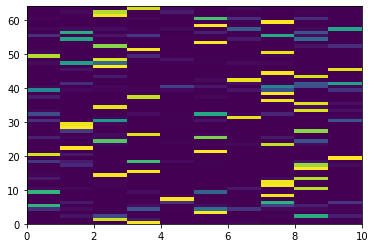

In [83]:
plt.pcolor(cond.data.cpu().view(64,-1))

In [66]:
batch["target_image_label"]

tensor([2, 2, 7, 0, 2, 6, 5, 3, 8, 0, 7, 8, 8, 7, 1, 3, 9, 1, 2, 3, 6, 6, 9, 3,
        1, 8, 2, 9, 4, 7, 8, 7, 2, 5, 9, 5, 8, 6, 8, 6, 5, 7, 2, 7, 3, 7, 1, 9,
        1, 6, 6, 3, 9, 0, 4, 3, 7, 1, 0, 8, 0, 1, 1, 3])

In [91]:
digits_cond = {i: [] for i in range(10)}
embedding_arg_max = {i: [] for i in range(10)}

In [92]:
for i in range(1000):
    emb = embeddings[0.5](torch.tensor(i).to(device))
    arg_max = emb.argmax().item()
    label = qmnist_full_train_set[i]["target_image_label"].item()
    digits_cond[label].append(emb.data.cpu().view(-1))
    embedding_arg_max[arg_max].append(label)

In [70]:
from collections import Counter

In [71]:
embedding_arg_max_counters = {
    i: Counter(embedding_arg_max[i])
    for i in range(10)
}

In [72]:
[max(embedding_arg_max_counters[i].values()) for i in range(10)]

[13, 19, 19, 14, 12, 15, 20, 10, 14, 16]

In [90]:
embedding_arg_max_counters

{0: Counter({0: 10, 8: 8, 4: 8, 2: 9, 3: 12, 1: 13, 6: 8, 9: 11, 7: 3, 5: 2}),
 1: Counter({3: 12,
          6: 8,
          0: 12,
          9: 19,
          8: 10,
          1: 13,
          4: 14,
          5: 9,
          7: 18,
          2: 11}),
 2: Counter({9: 17,
          5: 19,
          8: 12,
          0: 13,
          6: 9,
          7: 14,
          3: 11,
          1: 14,
          2: 10,
          4: 5}),
 3: Counter({4: 9,
          6: 8,
          1: 13,
          7: 7,
          2: 11,
          3: 14,
          0: 10,
          5: 10,
          8: 10,
          9: 3}),
 4: Counter({1: 9, 0: 3, 7: 5, 2: 10, 8: 6, 6: 10, 3: 12, 4: 10, 5: 7, 9: 7}),
 5: Counter({9: 5, 6: 10, 8: 10, 3: 8, 7: 13, 2: 15, 4: 13, 5: 9, 0: 8, 1: 5}),
 6: Counter({8: 15,
          7: 17,
          0: 20,
          1: 17,
          4: 12,
          3: 19,
          9: 13,
          5: 6,
          6: 12,
          2: 7}),
 7: Counter({5: 4, 7: 8, 1: 7, 4: 10, 0: 6, 6: 10, 2: 6, 3: 7, 8: 7, 9: 

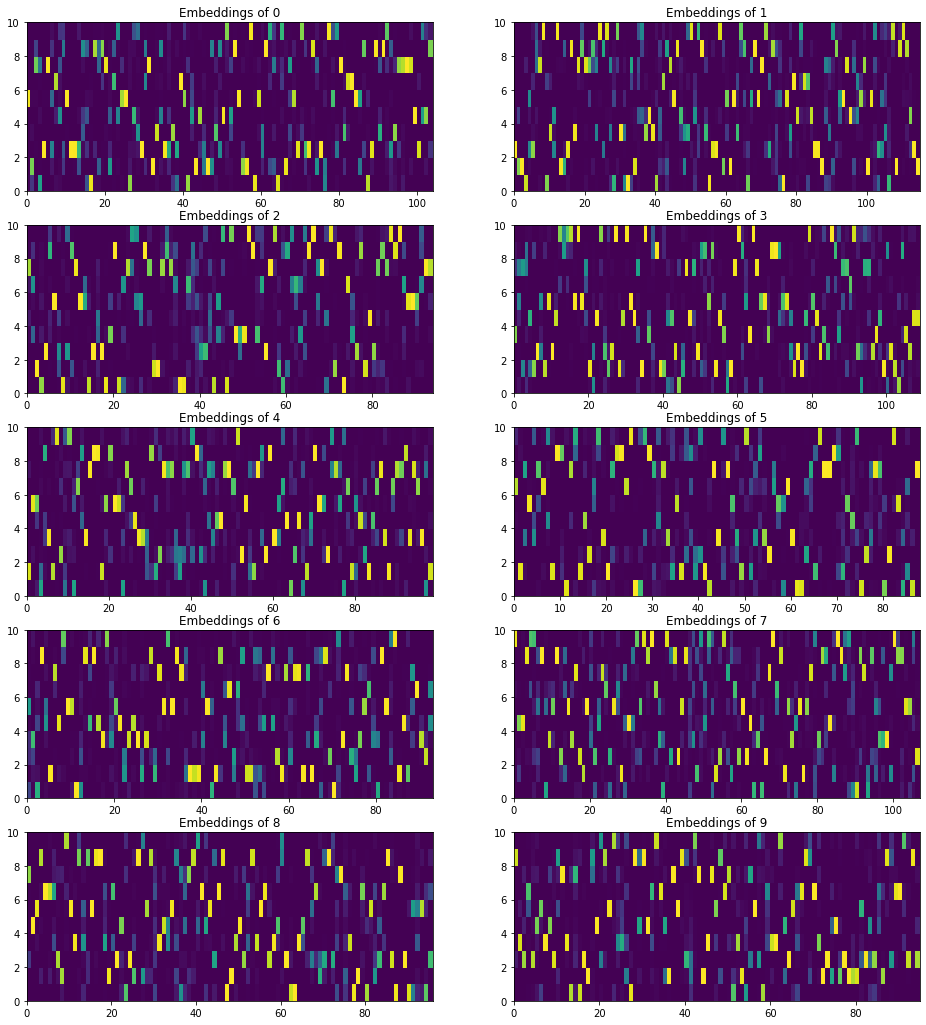

In [93]:
fig, axs = plt.subplots(5,2,figsize=(16,18))
for digit in range(10):
    axs[digit//2, digit%2].set_title(f"Embeddings of {digit}")
    axs[digit//2, digit%2].pcolor(np.vstack(digits_cond[digit]).T)
plt.show()

In [93]:
from sklearn.cluster import KMeans


In [95]:
X = embeddings[10].weight.cpu().detach().clone()

In [96]:
X

tensor([[ 0.3797, -1.3101,  1.1682,  ..., -2.0476, -1.0355,  0.1320],
        [-0.8534, -0.2286,  1.5897,  ...,  0.8616,  0.7335, -0.6468],
        [ 1.4400,  0.1017,  0.1994,  ...,  0.3151,  0.6235,  1.6456],
        ...,
        [-0.3176,  1.4003, -0.2599,  ..., -0.3856, -2.4457, -0.6170],
        [ 0.0880,  0.9057, -1.9359,  ...,  0.3370, -0.0324,  0.4879],
        [-0.0091,  0.0884, -1.9657,  ...,  1.9115, -0.9577, -0.6605]])

In [97]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

In [98]:
kmeans.labels_

array([3, 2, 3, ..., 4, 7, 7], dtype=int32)

In [105]:
data_labels = np.zeros(1500)
for i in range(1500):
    data_labels[i] = qmnist_full_train_set[i]["target_image_label"].item()

In [ ]:
data_labels[:10]

In [110]:
kmeans_labels = {i: Counter() for i in range(10)}

In [111]:
for i, label in enumerate(data_labels):
    kmean_lbl = kmeans.labels_[i]
    kmeans_labels[kmean_lbl][int(label)] += 1

In [112]:
kmeans_labels

{0: Counter({5: 11,
          9: 21,
          4: 20,
          1: 10,
          8: 23,
          2: 12,
          3: 15,
          6: 22,
          0: 1,
          7: 9}),
 1: Counter({3: 28, 8: 18, 2: 26, 5: 23, 1: 24, 0: 28, 7: 10, 4: 14, 6: 13}),
 2: Counter({1: 16,
          7: 44,
          9: 5,
          0: 15,
          5: 7,
          3: 36,
          8: 12,
          4: 5,
          2: 22,
          6: 11}),
 3: Counter({0: 29,
          2: 22,
          6: 18,
          8: 13,
          3: 13,
          1: 8,
          7: 13,
          5: 9,
          4: 5,
          9: 8}),
 4: Counter({1: 20,
          8: 17,
          4: 19,
          6: 10,
          9: 18,
          2: 12,
          0: 10,
          7: 19,
          3: 10,
          5: 12}),
 5: Counter({4: 17,
          6: 11,
          9: 12,
          1: 9,
          7: 7,
          5: 22,
          2: 18,
          3: 13,
          8: 18,
          0: 5}),
 6: Counter({4: 19,
          8: 15,
          5: 27,
     